In [556]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mlxtend.data as mld
import warnings as w
w.filterwarnings('ignore')


In [10]:
train_data,train_label = mld.loadlocal_mnist(images_path='../../DataSets/MNIST/train-images-mnist.idx3-ubyte', # extract zip file
                        labels_path='../../DataSets/MNIST/train-labels-mnist.idx1-ubyte')

test_data,test_label = mld.loadlocal_mnist(images_path='../../DataSets/MNIST/test-images-mnist.idx3-ubyte', # extract zip file
                        labels_path='../../DataSets/MNIST/test-labels-mnist.idx1-ubyte')


In [39]:
train_data = train_data/train_data.max()
test_data = test_data/test_data.max()

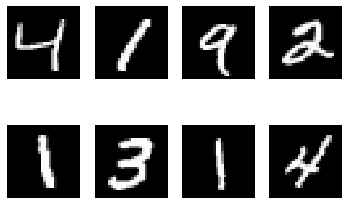

In [40]:
for i in range(1,9):
    plt.subplot(240+i)
    plt.axis('off')
    plt.imshow(train_data[1+i,:].reshape(28,28), cmap='gray')
plt.show()

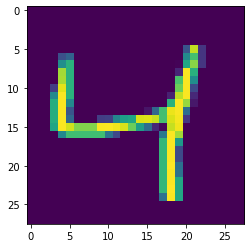

In [25]:
plt.imshow(train_data[2,:].reshape(28,28))

In [32]:
len(np.unique(train_label))

10

In [561]:
class NeuralNetwork():
    
    def __init__(self):
        
        self.layers_n       = []
        self.theta_layers   = []
        self.bias           = []
        self.activation_func= []
        self.activations    = []
        self.dL_dA          = []
        self.dL_dtheta      = []
        self.dL_dbias       = []
        self.itera          = []
        self.csfun          = []
                
    def add(self , neuron , activation_function = 'relu'):
        '''You have to give the no. of neurons you want to given layer.
            First layer neurons = no. of columns of your data
            
            default activation function is 'relu' you can change to 'sigmoid' , 'softmax' also
        '''
        self.layers_n.append(neuron)
        
        if activation_function == 'sigmoid' or activation_function == 'relu' or activation_function == 'softmax':
            self.activation_func.append(activation_function)
        else:
            raise TypeError('Pass only relu or sigmoid , and softmax for last layer')
    
    def one_hot_label(self , y):
        one_hot_labels = np.zeros((y.shape[0] , self.layers_n[-1]))
        for i in range(y.shape[0]):  
            one_hot_labels[i, y[i] ] = 1
        return one_hot_labels
    
    
    def fit(self , X , y , batch_size = 128 , alpha = 0.01 , epoche = 100,lmda = .01):
        for i in range(len(self.layers_n)-1): 
            self.theta_layers.append(np.random.randn(self.layers_n[i],self.layers_n[i+1]))
            
            self.bias.append((np.random.randn(self.layers_n[i+1])))
        
        return self.gradientDecent( X , y , batch_size , alpha , epoche )
    
    def softmax(self , activation , theta , bias):
        exp = np.exp( np.dot( activation , theta ) + bias)
        denominator = np.sum( exp , axis = 1)
        s = list(map(lambda i : exp[:,i] / denominator , np.arange(self.layers_n[-1])))
        return np.array(s).T
    
    def relu(self,activation,theta, bias):
        q = (np.dot(activation , theta) + bias)
        return np.clip(q , a_min=0 , a_max = q)
    
    def sigmoid(self, activation , theta , bias):
        return  1 / (1 + np.exp(np.dot(activation , theta) +  bias))
    
    def forwardPropagation(self,X):
        
        self.activations    = []
        
        self.activations.append(X)
        for i in range(len(self.layers_n)-2):
            self.activations.append(self.relu(self.activations[i] , self.theta_layers[i] , self.bias[i]))
                      
        self.activations.append(self.softmax(self.activations[-1] , self.theta_layers[-1] , self.bias[-1]))
        
    def costFunction(self,X,y):
        
        self.y = self.one_hot_label(y)
        self.forwardPropagation(X)
        
        np.nan_to_num(self.activations[-1] , copy = False)
        self.crossEntropy = 1 * np.log(self.activations[-1])
        np.nan_to_num(self.crossEntropy, copy=False)
        
        #regu = self.lmda * (np.sum(self.theta_layer1)**2 + np.sum(self.theta_layer2)**2 + np.sum(self.theta_layer3)**2 + np.sum(self.theta_layer4)**2)
        return (1/X.shape[0] * -np.sum(self.crossEntropy)) #+ regu  # regu = 0 bcz lmda is zero 
      
    
    def costFunctionDerivative(self,X,y,alpha):
        
        self.dL_dA          = []
        self.dL_dtheta      = []
        self.dL_dbias       = []
        
        self.forwardPropagation(X)
        
        self.y_cap = self.activations[-1]
        self.target_y = self.one_hot_label(y)
        self.dL_dA.append(self.y_cap - self.target_y)
        
        for i in range(len(self.layers_n)-2):   
            
            self.dL_dA.append( np.dot( self.dL_dA[i] , self.theta_layers[-1-i].T ) )
        
        for i in range(len(self.layers_n)-1):  
            
            # Storing derivative in a list
            self.dL_dtheta.append(1/X.shape[0] * (np.dot(self.activations[-2-i].T , self.dL_dA[i]))) 
            self.dL_dbias.append(1/X.shape[0] * self.dL_dA[i])
        
        for i in range(len(self.layers_n)-1):  
            
            # updating parameters
            self.theta_layers[i]    -= (alpha * self.dL_dtheta[-1-i])  
            self.bias[-1-i]         -= (alpha * self.dL_dbias[i].sum(axis = 0))                  
            
            # dont get confuse by [-1-i] . Actually derivative are calculated during backpropagation
            # and original values are initialized during forward propagation so derivative are stored in
            # reverse order while data's stored in forward order
      
    def gradientDecent(self , X , y , batch , alpha , epoche  ):
        i = 1
        while i < epoche:
            
            index = np.random.randint(0 , X.shape[0] , size=(batch,))
        
            initial_cost = self.costFunction(X[index] , y[index] )
       
            self.costFunctionDerivative(X[index], y[index],alpha )
        
            print('Iteration {} Cost function {}'.format(i , initial_cost ))    
        
            self.itera.append(i)
            self.csfun.append(initial_cost)
            i+=1
            
        final_cost = self.costFunction(X[index] , y[index] )
        self.itera.append(i)
        self.csfun.append(final_cost)
            
        
            
    def gradient_plot(self):
        plt.plot(self.itera[10:],self.csfun[10:])
         
        
    def accuracy(self , X , y):
        self.forwardPropagation(X)
        pred = np.argmax(self.activations[-1],axis=1)
        c1 = 0
        for i,j in enumerate(y):
            if j == pred[i]:
                c1+=1
        print("Accuracy : ",(c1/y.shape[0])*100,'%')
        
    def predict(self,X):
        self.forwardPropagation(X)
        return np.argmax(self.activations[-1],axis = 1)
    
    def predict_prob(self,X):
        self.forwardPropagation(X)
        return self.activations[-1]
        


In [63]:
NN = NeuralNetwork()
NN.add(784)
NN.add(200)
NN.add(10)
NN.fit(train_data,train_label,alpha=0.099,epoche = 3500,batch_size = 2000)

Iteration 1 Cost function 151.64273349378354
Iteration 2 Cost function 115.18026829304098
Iteration 3 Cost function 79.10017007250549
Iteration 4 Cost function 61.72619067326887
Iteration 5 Cost function 49.851162273445595
Iteration 6 Cost function 44.21319968171255
Iteration 7 Cost function 40.45837488395295
Iteration 8 Cost function 35.08504942323135
Iteration 9 Cost function 37.34343109237714
Iteration 10 Cost function 26.928857973110727
Iteration 11 Cost function 25.61899643193125
Iteration 12 Cost function 22.022388250204813
Iteration 13 Cost function 21.583241637218354
Iteration 14 Cost function 22.32802237756684
Iteration 15 Cost function 25.163303439510567
Iteration 16 Cost function 19.922653095476402
Iteration 17 Cost function 17.609736178797128
Iteration 18 Cost function 15.637873393309354
Iteration 19 Cost function 18.023703946044336
Iteration 20 Cost function 16.775329689041268
Iteration 21 Cost function 15.87640778426606
Iteration 22 Cost function 14.660457397114634
Iterat

Iteration 181 Cost function 5.028119125032298
Iteration 182 Cost function 5.550687456205767
Iteration 183 Cost function 5.744512175501716
Iteration 184 Cost function 5.182692481657738
Iteration 185 Cost function 5.8865739784412305
Iteration 186 Cost function 4.906963664206508
Iteration 187 Cost function 5.047569846438138
Iteration 188 Cost function 5.138637545456504
Iteration 189 Cost function 5.74042284385812
Iteration 190 Cost function 5.067499472462524
Iteration 191 Cost function 5.6683658587786345
Iteration 192 Cost function 4.982308465788794
Iteration 193 Cost function 4.882008496782521
Iteration 194 Cost function 5.410208785422107
Iteration 195 Cost function 5.077997120815221
Iteration 196 Cost function 5.202242938853315
Iteration 197 Cost function 4.687160844401757
Iteration 198 Cost function 5.277067124244682
Iteration 199 Cost function 4.6545854414960806
Iteration 200 Cost function 5.3872209755135865
Iteration 201 Cost function 4.970956495874367
Iteration 202 Cost function 5.3

Iteration 360 Cost function 3.9154254624366223
Iteration 361 Cost function 3.7248275323768367
Iteration 362 Cost function 3.9104795161500805
Iteration 363 Cost function 4.3859226733161165
Iteration 364 Cost function 3.1926540784438693
Iteration 365 Cost function 4.11295088761964
Iteration 366 Cost function 3.6041078669455024
Iteration 367 Cost function 3.507180881184291
Iteration 368 Cost function 3.805642507730868
Iteration 369 Cost function 4.081335673649248
Iteration 370 Cost function 4.086402212269729
Iteration 371 Cost function 3.9186286499485683
Iteration 372 Cost function 3.474397724761117
Iteration 373 Cost function 4.264025754128082
Iteration 374 Cost function 4.102477087663601
Iteration 375 Cost function 4.1759750362731305
Iteration 376 Cost function 4.0482534602609395
Iteration 377 Cost function 3.590949287183588
Iteration 378 Cost function 3.5475518891737168
Iteration 379 Cost function 3.741835934220195
Iteration 380 Cost function 3.0766054333945516
Iteration 381 Cost funct

Iteration 539 Cost function 2.9837865401505366
Iteration 540 Cost function 2.754673014703907
Iteration 541 Cost function 3.621614578964308
Iteration 542 Cost function 2.8488875829728015
Iteration 543 Cost function 3.1011642450134542
Iteration 544 Cost function 2.8927112290160593
Iteration 545 Cost function 2.739603747311239
Iteration 546 Cost function 3.013963543579991
Iteration 547 Cost function 3.044504902037019
Iteration 548 Cost function 3.290441054185685
Iteration 549 Cost function 3.412189565933489
Iteration 550 Cost function 3.4754814568120516
Iteration 551 Cost function 2.9882052462307684
Iteration 552 Cost function 3.4723569295078596
Iteration 553 Cost function 2.948126884154833
Iteration 554 Cost function 3.1411817293290376
Iteration 555 Cost function 2.9257583290104376
Iteration 556 Cost function 2.977450908284179
Iteration 557 Cost function 2.834419948589985
Iteration 558 Cost function 2.654215798190483
Iteration 559 Cost function 3.0921077569570588
Iteration 560 Cost funct

Iteration 719 Cost function 3.346930084391989
Iteration 720 Cost function 2.9775328520869473
Iteration 721 Cost function 2.4100649916597074
Iteration 722 Cost function 2.310191194298822
Iteration 723 Cost function 2.397168647392278
Iteration 724 Cost function 2.50452888801248
Iteration 725 Cost function 3.016867830070427
Iteration 726 Cost function 2.7686574357391787
Iteration 727 Cost function 2.861563512654143
Iteration 728 Cost function 3.015452335921111
Iteration 729 Cost function 2.6770544918872985
Iteration 730 Cost function 2.446115510057379
Iteration 731 Cost function 2.728619651797164
Iteration 732 Cost function 2.247765600103297
Iteration 733 Cost function 2.701193584066288
Iteration 734 Cost function 2.470867666942365
Iteration 735 Cost function 2.6912112613503267
Iteration 736 Cost function 2.2807238775787138
Iteration 737 Cost function 2.4475448275322425
Iteration 738 Cost function 2.4962427015702553
Iteration 739 Cost function 2.7773105472466284
Iteration 740 Cost functio

Iteration 899 Cost function 2.2655817693228313
Iteration 900 Cost function 2.4159520685287403
Iteration 901 Cost function 2.0155387510246565
Iteration 902 Cost function 2.2761622104373864
Iteration 903 Cost function 2.1237502005160493
Iteration 904 Cost function 2.201222623494172
Iteration 905 Cost function 2.224316086098277
Iteration 906 Cost function 1.858539240122801
Iteration 907 Cost function 2.58283268256395
Iteration 908 Cost function 2.2090972972040026
Iteration 909 Cost function 2.4290624013217115
Iteration 910 Cost function 2.2715250293200437
Iteration 911 Cost function 2.5434744687012674
Iteration 912 Cost function 2.0752166677256154
Iteration 913 Cost function 2.446563805003234
Iteration 914 Cost function 2.4955422334209705
Iteration 915 Cost function 2.456038374010617
Iteration 916 Cost function 2.3181371184280097
Iteration 917 Cost function 1.9632825306124833
Iteration 918 Cost function 2.5890925825263342
Iteration 919 Cost function 1.8895837033481067
Iteration 920 Cost f

Iteration 1076 Cost function 1.7805152842156313
Iteration 1077 Cost function 2.0774209199025244
Iteration 1078 Cost function 1.934318142573041
Iteration 1079 Cost function 2.324254455400725
Iteration 1080 Cost function 2.0677882321758156
Iteration 1081 Cost function 2.045771118253076
Iteration 1082 Cost function 2.108335643800575
Iteration 1083 Cost function 1.9839551120621868
Iteration 1084 Cost function 1.9285497543411017
Iteration 1085 Cost function 2.0334400138524433
Iteration 1086 Cost function 2.14540560741582
Iteration 1087 Cost function 2.17873970735788
Iteration 1088 Cost function 2.177223652405088
Iteration 1089 Cost function 2.201696403034238
Iteration 1090 Cost function 1.7576406595966196
Iteration 1091 Cost function 1.800032906506123
Iteration 1092 Cost function 1.9557636075473532
Iteration 1093 Cost function 1.9140587414902348
Iteration 1094 Cost function 1.797276724808777
Iteration 1095 Cost function 1.714873272357265
Iteration 1096 Cost function 2.291320901096339
Iterat

Iteration 1252 Cost function 1.6948019361929583
Iteration 1253 Cost function 1.739927983601327
Iteration 1254 Cost function 2.1223487241224714
Iteration 1255 Cost function 1.39356290499257
Iteration 1256 Cost function 1.7245759984281153
Iteration 1257 Cost function 1.6416795468156251
Iteration 1258 Cost function 2.023413403273866
Iteration 1259 Cost function 1.7708625958976323
Iteration 1260 Cost function 1.691889298624705
Iteration 1261 Cost function 1.349092586333049
Iteration 1262 Cost function 1.8968023438203132
Iteration 1263 Cost function 1.7719545611460454
Iteration 1264 Cost function 1.6156983798566942
Iteration 1265 Cost function 2.0334157730025693
Iteration 1266 Cost function 2.0180900193390783
Iteration 1267 Cost function 1.8048404046047426
Iteration 1268 Cost function 1.7978206132730539
Iteration 1269 Cost function 1.685189635223161
Iteration 1270 Cost function 1.8204455224801281
Iteration 1271 Cost function 1.5694523433150969
Iteration 1272 Cost function 2.041496255796097


Iteration 1426 Cost function 1.7086381553363224
Iteration 1427 Cost function 1.7431226991508162
Iteration 1428 Cost function 1.7569741605090516
Iteration 1429 Cost function 1.6231457275564891
Iteration 1430 Cost function 1.5681830560189658
Iteration 1431 Cost function 1.3665647824129878
Iteration 1432 Cost function 1.5076949620403715
Iteration 1433 Cost function 1.6595460836500433
Iteration 1434 Cost function 1.4925387130817405
Iteration 1435 Cost function 1.7029893100579157
Iteration 1436 Cost function 1.4038954842808757
Iteration 1437 Cost function 1.2897677182552036
Iteration 1438 Cost function 1.4982541797121922
Iteration 1439 Cost function 1.3573547378079884
Iteration 1440 Cost function 1.6385763312806767
Iteration 1441 Cost function 1.5718688314504483
Iteration 1442 Cost function 1.6508949241518527
Iteration 1443 Cost function 1.7909776953180667
Iteration 1444 Cost function 1.42910033262672
Iteration 1445 Cost function 1.605742003522819
Iteration 1446 Cost function 1.450485583758

Iteration 1598 Cost function 1.3695899822911428
Iteration 1599 Cost function 1.501789737497771
Iteration 1600 Cost function 1.4271679940473587
Iteration 1601 Cost function 1.314689150839152
Iteration 1602 Cost function 1.3014370238246815
Iteration 1603 Cost function 1.5731712339891122
Iteration 1604 Cost function 1.3462613362426994
Iteration 1605 Cost function 1.6434608592214277
Iteration 1606 Cost function 1.247714327774459
Iteration 1607 Cost function 1.335230996747255
Iteration 1608 Cost function 1.661439368951993
Iteration 1609 Cost function 1.0769864484524494
Iteration 1610 Cost function 1.4757922034477242
Iteration 1611 Cost function 1.6881006231556837
Iteration 1612 Cost function 1.5108384926409122
Iteration 1613 Cost function 1.5702370254849112
Iteration 1614 Cost function 1.3053350165475552
Iteration 1615 Cost function 1.5703145584612312
Iteration 1616 Cost function 1.1177982253685945
Iteration 1617 Cost function 1.15864882503485
Iteration 1618 Cost function 1.353865073636127


Iteration 1769 Cost function 1.5607521457985878
Iteration 1770 Cost function 1.5895679540456562
Iteration 1771 Cost function 1.4494503798966256
Iteration 1772 Cost function 1.4128846951168093
Iteration 1773 Cost function 1.093367849847717
Iteration 1774 Cost function 1.3173935461825617
Iteration 1775 Cost function 1.0610230672218264
Iteration 1776 Cost function 1.3207565054777366
Iteration 1777 Cost function 1.11796643213923
Iteration 1778 Cost function 1.4489470999379945
Iteration 1779 Cost function 1.3704435506980368
Iteration 1780 Cost function 1.3352833318675903
Iteration 1781 Cost function 1.2610555746203322
Iteration 1782 Cost function 1.3196477494517145
Iteration 1783 Cost function 1.1582054361079737
Iteration 1784 Cost function 1.529253776693223
Iteration 1785 Cost function 1.3670776351078238
Iteration 1786 Cost function 1.4765929549330827
Iteration 1787 Cost function 1.169721928158974
Iteration 1788 Cost function 1.4417390128032175
Iteration 1789 Cost function 1.36214219591988

Iteration 1944 Cost function 1.222405032221097
Iteration 1945 Cost function 1.3141617217669224
Iteration 1946 Cost function 1.3972467499042736
Iteration 1947 Cost function 1.0650494142111735
Iteration 1948 Cost function 1.1505218457431594
Iteration 1949 Cost function 1.2598508839049851
Iteration 1950 Cost function 1.1902012202809016
Iteration 1951 Cost function 1.234058524842696
Iteration 1952 Cost function 1.1818104528521847
Iteration 1953 Cost function 1.2064045236756913
Iteration 1954 Cost function 1.0932106051423802
Iteration 1955 Cost function 1.1086273505204873
Iteration 1956 Cost function 1.270485341467897
Iteration 1957 Cost function 1.2621195700394467
Iteration 1958 Cost function 1.1410998682225755
Iteration 1959 Cost function 1.2920233521863609
Iteration 1960 Cost function 1.3227886906546547
Iteration 1961 Cost function 1.1504646826356468
Iteration 1962 Cost function 1.1493843912919206
Iteration 1963 Cost function 1.263527105297906
Iteration 1964 Cost function 1.2540287653317

Iteration 2119 Cost function 1.2005904322912213
Iteration 2120 Cost function 1.1033306648934953
Iteration 2121 Cost function 1.0945881540370395
Iteration 2122 Cost function 1.164360086330767
Iteration 2123 Cost function 0.9565465047243497
Iteration 2124 Cost function 1.1368066133819703
Iteration 2125 Cost function 1.2886209137321534
Iteration 2126 Cost function 1.1776443422734022
Iteration 2127 Cost function 1.2301999043348106
Iteration 2128 Cost function 1.249618705665972
Iteration 2129 Cost function 1.2996052182318936
Iteration 2130 Cost function 1.2014308412648218
Iteration 2131 Cost function 1.0752598804568334
Iteration 2132 Cost function 1.15380525043555
Iteration 2133 Cost function 1.1122270382171906
Iteration 2134 Cost function 1.1861137683438499
Iteration 2135 Cost function 1.1382421633692994
Iteration 2136 Cost function 1.1478427498014072
Iteration 2137 Cost function 1.299910389339819
Iteration 2138 Cost function 0.9657378822371709
Iteration 2139 Cost function 0.98503344295125

Iteration 2291 Cost function 1.0425339355439476
Iteration 2292 Cost function 0.956153096262838
Iteration 2293 Cost function 1.127476026255321
Iteration 2294 Cost function 1.044637859133276
Iteration 2295 Cost function 1.2012697641899541
Iteration 2296 Cost function 1.02652211893944
Iteration 2297 Cost function 0.9577444034119158
Iteration 2298 Cost function 1.216538186702556
Iteration 2299 Cost function 0.9544473326127039
Iteration 2300 Cost function 1.1461392272630933
Iteration 2301 Cost function 1.1889954026969598
Iteration 2302 Cost function 1.159074091495308
Iteration 2303 Cost function 1.0846580331997389
Iteration 2304 Cost function 1.061501862454435
Iteration 2305 Cost function 0.8993352642558754
Iteration 2306 Cost function 1.2325791835447877
Iteration 2307 Cost function 1.1019158498587847
Iteration 2308 Cost function 0.9961821782295549
Iteration 2309 Cost function 0.9270938615892742
Iteration 2310 Cost function 1.0357973393772972
Iteration 2311 Cost function 0.9943631225128239


Iteration 2465 Cost function 0.9342531269059257
Iteration 2466 Cost function 0.9169529125132234
Iteration 2467 Cost function 1.0558588833510119
Iteration 2468 Cost function 1.0133158465107817
Iteration 2469 Cost function 0.9410450429688669
Iteration 2470 Cost function 1.0349196758020713
Iteration 2471 Cost function 0.8966799060675585
Iteration 2472 Cost function 1.0595702008114256
Iteration 2473 Cost function 0.9675369441062825
Iteration 2474 Cost function 0.9916252793975803
Iteration 2475 Cost function 0.992993030058949
Iteration 2476 Cost function 0.8519425404292521
Iteration 2477 Cost function 0.878488042001917
Iteration 2478 Cost function 1.0444621676405246
Iteration 2479 Cost function 0.8851366737036613
Iteration 2480 Cost function 0.7854934403765578
Iteration 2481 Cost function 0.8589108148792234
Iteration 2482 Cost function 0.8805631097792693
Iteration 2483 Cost function 0.927072870474056
Iteration 2484 Cost function 0.9290585627687251
Iteration 2485 Cost function 1.051992204691

Iteration 2638 Cost function 0.9792678366268631
Iteration 2639 Cost function 0.889239639249029
Iteration 2640 Cost function 0.9504285807911959
Iteration 2641 Cost function 0.8496695536525717
Iteration 2642 Cost function 1.015564353477355
Iteration 2643 Cost function 0.9103527793730118
Iteration 2644 Cost function 1.0995050139224227
Iteration 2645 Cost function 0.6588131651441779
Iteration 2646 Cost function 0.9612451076105782
Iteration 2647 Cost function 0.9285957074409394
Iteration 2648 Cost function 0.8113610648482406
Iteration 2649 Cost function 0.8638782498841991
Iteration 2650 Cost function 1.0038846632820748
Iteration 2651 Cost function 0.714410731316931
Iteration 2652 Cost function 0.8423492795703472
Iteration 2653 Cost function 0.9334423697341413
Iteration 2654 Cost function 0.8324363092430722
Iteration 2655 Cost function 0.6785819564555577
Iteration 2656 Cost function 0.8254011807757244
Iteration 2657 Cost function 0.8797947792980139
Iteration 2658 Cost function 0.928790186980

Iteration 2809 Cost function 0.7817958686008536
Iteration 2810 Cost function 0.9645321982670833
Iteration 2811 Cost function 0.7636214199569739
Iteration 2812 Cost function 0.850243162843707
Iteration 2813 Cost function 0.7857469632438194
Iteration 2814 Cost function 0.8510200600950285
Iteration 2815 Cost function 0.8672978361736211
Iteration 2816 Cost function 0.9276866814836424
Iteration 2817 Cost function 0.8295907519292487
Iteration 2818 Cost function 0.9359443768564363
Iteration 2819 Cost function 0.867743729985486
Iteration 2820 Cost function 0.8062440601487104
Iteration 2821 Cost function 0.8304980646349102
Iteration 2822 Cost function 0.8339972990285852
Iteration 2823 Cost function 0.9802152955723359
Iteration 2824 Cost function 0.7708705011726115
Iteration 2825 Cost function 0.8129492280703492
Iteration 2826 Cost function 0.7893945531828473
Iteration 2827 Cost function 0.8406347393462202
Iteration 2828 Cost function 0.7950552957939777
Iteration 2829 Cost function 0.75824948488

Iteration 2980 Cost function 0.6557900945562437
Iteration 2981 Cost function 0.8128322841113815
Iteration 2982 Cost function 0.6087055242410142
Iteration 2983 Cost function 0.8929133959356476
Iteration 2984 Cost function 0.5365323050855111
Iteration 2985 Cost function 0.8867082739583522
Iteration 2986 Cost function 0.9266868707611905
Iteration 2987 Cost function 0.8424682884574073
Iteration 2988 Cost function 0.7023285302879477
Iteration 2989 Cost function 0.8516493320986153
Iteration 2990 Cost function 0.8920879245043428
Iteration 2991 Cost function 0.8691279617097551
Iteration 2992 Cost function 0.8234299008034889
Iteration 2993 Cost function 0.8017693095507056
Iteration 2994 Cost function 0.8805091459667023
Iteration 2995 Cost function 0.8387661328886276
Iteration 2996 Cost function 0.8723273349193026
Iteration 2997 Cost function 0.8977661697570614
Iteration 2998 Cost function 0.864624905346903
Iteration 2999 Cost function 0.8846459261840461
Iteration 3000 Cost function 0.9516837208

Iteration 3151 Cost function 0.9067469276026682
Iteration 3152 Cost function 0.6700590587948315
Iteration 3153 Cost function 0.7836947656469821
Iteration 3154 Cost function 0.7856662730477444
Iteration 3155 Cost function 0.8623039772415863
Iteration 3156 Cost function 0.7376182528763088
Iteration 3157 Cost function 0.6359727398230317
Iteration 3158 Cost function 0.767619879839643
Iteration 3159 Cost function 0.829328236831522
Iteration 3160 Cost function 0.8561083603495669
Iteration 3161 Cost function 0.7319883956194232
Iteration 3162 Cost function 0.5533333899198932
Iteration 3163 Cost function 0.9032450937327242
Iteration 3164 Cost function 0.6946322394267832
Iteration 3165 Cost function 0.6974316441254257
Iteration 3166 Cost function 0.7769140865543132
Iteration 3167 Cost function 0.623590283974057
Iteration 3168 Cost function 0.6946153077145689
Iteration 3169 Cost function 0.7559527624872467
Iteration 3170 Cost function 0.8979550465801276
Iteration 3171 Cost function 0.841181866625

Iteration 3324 Cost function 0.6856359071284281
Iteration 3325 Cost function 0.7337736966106646
Iteration 3326 Cost function 0.7470658259387238
Iteration 3327 Cost function 0.7929854543551597
Iteration 3328 Cost function 0.8455156076631587
Iteration 3329 Cost function 0.6465307771490925
Iteration 3330 Cost function 0.6584114209395174
Iteration 3331 Cost function 0.806627337363681
Iteration 3332 Cost function 0.7935071012276238
Iteration 3333 Cost function 0.7451551785740547
Iteration 3334 Cost function 0.6317274577022342
Iteration 3335 Cost function 0.6955502901908933
Iteration 3336 Cost function 0.7039651731515839
Iteration 3337 Cost function 0.7523433470894197
Iteration 3338 Cost function 0.6150094761161119
Iteration 3339 Cost function 0.6678840291066706
Iteration 3340 Cost function 0.6758771321979752
Iteration 3341 Cost function 0.6653944219534104
Iteration 3342 Cost function 0.7238607386793912
Iteration 3343 Cost function 0.7438250201853179
Iteration 3344 Cost function 0.7668696016

Iteration 3498 Cost function 0.803741466669534
Iteration 3499 Cost function 0.5666363126624085


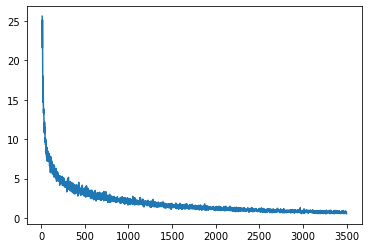

In [64]:
NN.gradient_plot()

In [70]:
NN.accuracy(test_data,test_label)
NN.accuracy(train_data,train_label)

Accuracy :  91.14 %
Accuracy :  91.97333333333333 %


# Lets look close what we find in first hidden layer network

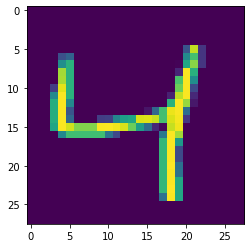

In [83]:
plt.imshow(train_data[2,:].reshape(28,28))

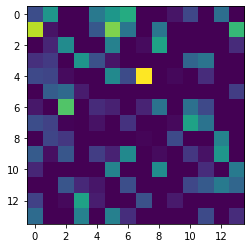

In [87]:
plt.imshow(NN.activations[1][2,:196].reshape(14,14))

# We trained our previous model with 200 neurons it's very small size of image if we resize them 
# Now i will pass 0,1,2 digits without shuffle with 1000 images 

In [606]:
inde5 = np.hstack(np.argwhere(train_label == 0))[:1000]
inde4 = np.hstack(np.argwhere(train_label == 1))[:1000]
inde3 = np.hstack(np.argwhere(train_label == 2))[:1000]

q = np.append(inde5,[inde4,inde3])

In [603]:
NN2 = NeuralNetwork()
NN2.add(784)
NN2.add(784)
NN2.add(3)
NN2.fit(train_data[q], train_label[q],batch_size = 1 , epoche = 1000 ,alpha=.001)

Iteration 1 Cost function 353.0459440152692
Iteration 2 Cost function 384.7668126821767
Iteration 3 Cost function 469.28174053586696
Iteration 4 Cost function 313.27873952992286
Iteration 5 Cost function 176.6444364727317
Iteration 6 Cost function 315.07102064070017
Iteration 7 Cost function 429.61297871052693
Iteration 8 Cost function 922.3091964453256
Iteration 9 Cost function 217.2026209598941
Iteration 10 Cost function 147.62897205353127
Iteration 11 Cost function 81.11160684888111
Iteration 12 Cost function 333.2847927912013
Iteration 13 Cost function 245.57947140227282
Iteration 14 Cost function 409.7697018132287
Iteration 15 Cost function 54.60439695727774
Iteration 16 Cost function 16.590248873995137
Iteration 17 Cost function 432.71442410978045
Iteration 18 Cost function 173.62314371677974
Iteration 19 Cost function 16.84839582338536
Iteration 20 Cost function 419.43460295699373
Iteration 21 Cost function 333.9183813635786
Iteration 22 Cost function 228.1538901965784
Iteration

Iteration 180 Cost function 100.98467983174696
Iteration 181 Cost function 954.5257156608754
Iteration 182 Cost function 505.2289156745358
Iteration 183 Cost function 340.3807320355004
Iteration 184 Cost function 381.1238776696691
Iteration 185 Cost function 1008.8103789681852
Iteration 186 Cost function 398.99016764912767
Iteration 187 Cost function 842.5996082553478
Iteration 188 Cost function 438.13327276154484
Iteration 189 Cost function 830.2479808458415
Iteration 190 Cost function 749.859953786039
Iteration 191 Cost function 930.4849131817688
Iteration 192 Cost function 887.7650252859472
Iteration 193 Cost function 976.8019895424056
Iteration 194 Cost function 1.7976931348623157e+308
Iteration 195 Cost function 561.7601180633046
Iteration 196 Cost function 487.3311907914425
Iteration 197 Cost function 415.2674654506951
Iteration 198 Cost function 834.8419265105869
Iteration 199 Cost function 316.2865871467417
Iteration 200 Cost function 186.171158913125
Iteration 201 Cost functio

Iteration 358 Cost function 533.4107747153939
Iteration 359 Cost function 600.8625948453059
Iteration 360 Cost function 175.3953472645722
Iteration 361 Cost function 600.6367615011019
Iteration 362 Cost function 1.7976931348623157e+308
Iteration 363 Cost function 676.1845931968865
Iteration 364 Cost function 285.95469533985954
Iteration 365 Cost function 724.9632660295254
Iteration 366 Cost function 195.34862556244076
Iteration 367 Cost function 481.8884064401851
Iteration 368 Cost function 595.6915241519116
Iteration 369 Cost function 526.8853854778487
Iteration 370 Cost function 294.5899203527018
Iteration 371 Cost function 437.1561685242847
Iteration 372 Cost function 649.2698745196706
Iteration 373 Cost function 412.5559037992814
Iteration 374 Cost function 700.2302981504727
Iteration 375 Cost function 732.4281992479158
Iteration 376 Cost function 240.98088616889834
Iteration 377 Cost function 737.2436327600033
Iteration 378 Cost function 678.5259019504241
Iteration 379 Cost functi

Iteration 541 Cost function 725.5357355014385
Iteration 542 Cost function 183.85904813917708
Iteration 543 Cost function 1009.0969450809987
Iteration 544 Cost function 949.2543268797233
Iteration 545 Cost function 716.4962189721803
Iteration 546 Cost function 986.1419694433287
Iteration 547 Cost function 628.5374356256957
Iteration 548 Cost function 1130.7909349875183
Iteration 549 Cost function 865.5303343805036
Iteration 550 Cost function 699.0124912413535
Iteration 551 Cost function 321.13283723447256
Iteration 552 Cost function 806.9122911962052
Iteration 553 Cost function 861.490464951288
Iteration 554 Cost function 581.2763044719354
Iteration 555 Cost function 596.3133746785448
Iteration 556 Cost function 162.5143281786566
Iteration 557 Cost function 756.3991323778266
Iteration 558 Cost function 666.8808845787057
Iteration 559 Cost function 558.0589359535062
Iteration 560 Cost function 198.559385502036
Iteration 561 Cost function 936.5974975161298
Iteration 562 Cost function 649.

Iteration 724 Cost function 537.0779540637031
Iteration 725 Cost function 694.4685371126699
Iteration 726 Cost function 1047.156176750273
Iteration 727 Cost function 1068.5092867450815
Iteration 728 Cost function 640.1397914240065
Iteration 729 Cost function 484.40664417326605
Iteration 730 Cost function 303.4971103661367
Iteration 731 Cost function 580.9852225111315
Iteration 732 Cost function 425.3509315282149
Iteration 733 Cost function 957.2005167487521
Iteration 734 Cost function 750.9574179099802
Iteration 735 Cost function 194.87947174083936
Iteration 736 Cost function 584.6321759418252
Iteration 737 Cost function 1.7976931348623157e+308
Iteration 738 Cost function 589.6069472451977
Iteration 739 Cost function 626.4970726074566
Iteration 740 Cost function 442.3568701260541
Iteration 741 Cost function 783.0629688742913
Iteration 742 Cost function 808.9060033203446
Iteration 743 Cost function 829.433640268654
Iteration 744 Cost function 379.3271408849224
Iteration 745 Cost functio

Iteration 902 Cost function 1.7976931348623157e+308
Iteration 903 Cost function 633.4227514035501
Iteration 904 Cost function 582.3404719495442
Iteration 905 Cost function 548.3857106118631
Iteration 906 Cost function 740.9815351966743
Iteration 907 Cost function 188.7600532352527
Iteration 908 Cost function 905.8938348292143
Iteration 909 Cost function 606.021954535947
Iteration 910 Cost function 411.2484937518764
Iteration 911 Cost function 479.5527352518474
Iteration 912 Cost function 1297.7786706245975
Iteration 913 Cost function 506.86234971623276
Iteration 914 Cost function 512.3401490948756
Iteration 915 Cost function 568.7489769266499
Iteration 916 Cost function 327.14736656089207
Iteration 917 Cost function 722.686207683187
Iteration 918 Cost function 297.6888954698121
Iteration 919 Cost function 352.16973542634037
Iteration 920 Cost function 391.9949500583086
Iteration 921 Cost function 940.7131575064948
Iteration 922 Cost function 529.4462382115653
Iteration 923 Cost functio

In [604]:
NN2.accuracy(train_data[q],train_label[q])

Accuracy :  93.8 %


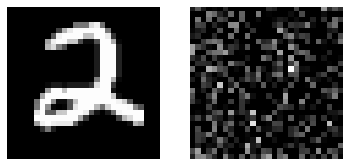

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [607]:
import pylab as pl
import scipy.stats as s
from IPython import display
import time

for i in range(1,3000,30):
    f = plt.figure()    
    f.add_subplot(1,2, 1)
    plt.axis('off')
    plt.imshow(train_data[q][i,:].reshape(28,28), cmap='gray')
    f.add_subplot(1,2, 2)
    plt.axis('off')
    plt.imshow(NN2.activations[-2][i,:].reshape(28,28), cmap='gray')
    display.clear_output(wait=True)
    display.display(pl.gcf())
    f.clear()